# Data Utilities

> Fill in a module description here

In [ ]:
#| default_exp utils

First, we evaluate how the datasets are loaded by the `nonlinear_benchmarks` library

In [ ]:
#| export
from nonlinear_benchmarks import *
from collections.abc import Iterator
from pathlib import Path
import numpy as np
import h5py
import os

In [ ]:
#| hide
from fastcore.test import test_eq,test_ne
import matplotlib.pyplot as plt

In [ ]:
#| export
def get_default_data_root() -> Path:
    """
    Returns the default root directory for datasets.

    Checks the 'IDENTIBENCH_DATA_ROOT' environment variable first,
    otherwise defaults to '~/.identibench_data'.
    """
    return Path(os.environ.get('IDENTIBENCH_DATA_ROOT', Path.home() / '.identibench_data'))


## Test utilities

In [ ]:
#| exporti
def _dummy_dataset_loader(
    save_path: Path, # Directory where the dummy dataset files will be written
    force_download: bool = False, # Argument for interface compatibility
    create_train_valid_dir: bool = False # If True, create a 'train_valid' subdir as well
    ) -> None:
    """Creates a dummy dataset structure with minimal HDF5 files for testing."""
    save_path = Path(save_path)
    if save_path.is_dir() and not force_download: return

    save_path.mkdir(parents=True, exist_ok=True)
    seq_len = 50
    subdirs = ['train', 'valid', 'test']
    if create_train_valid_dir:
        subdirs.append('train_valid')

    for subdir in subdirs:
        subdir_path = save_path / subdir
        subdir_path.mkdir(exist_ok=True)
        n_files = 1 if subdir == 'train_valid' else 2 # Create fewer files in train_valid for testing differentiation
        for i in range(n_files):
            dummy_file_path = subdir_path / f'{subdir}_{i}.hdf5'
            try:
                with h5py.File(dummy_file_path, 'w') as f:
                    f.create_dataset('u0', data=np.random.rand(seq_len).astype(np.float32))
                    f.create_dataset('u1', data=np.random.rand(seq_len).astype(np.float32))
                    f.create_dataset('y0', data=np.random.rand(seq_len).astype(np.float32))
                    f.attrs['fs'] = 10.0
            except Exception as e: print(f"Failed to create dummy file {dummy_file_path}: {e}")

In [ ]:
#| export
def hdf_files_from_path(fpath: Path) -> list[Path]:
        return sorted(list(fpath.glob('*.hdf5'))) 

## data utilities

In [ ]:
#| exporti
def _load_sequences_from_files(
        file_paths: list[Path],
        u_cols: list[str],
        y_cols: list[str],
        x_cols: list[str]|None = None,
        win_sz: int|None = None,
        stp_sz: int|None = None
    ) -> Iterator[tuple[np.ndarray, np.ndarray, np.ndarray|None]]:
    if not file_paths: return iter([]) 
    if win_sz is None and stp_sz is not None:
        raise ValueError("win_sz must be provided if stp_sz is provided")
    if stp_sz is None and win_sz is not None:
        raise ValueError("stp_sz must be provided if win_sz is provided")

    for file_path in file_paths:
        try:
            with h5py.File(file_path, 'r') as f:
                u_data = np.stack([f[col][()] for col in u_cols], axis=-1).astype(np.float32)
                y_data = np.stack([f[col][()] for col in y_cols], axis=-1).astype(np.float32)
                x_data = np.stack([f[col][()] for col in x_cols], axis=-1).astype(np.float32) if x_cols else None
        except Exception as e:
            print(f"Warning: Error reading {file_path}: {e}")
            continue

        if win_sz is None:
            yield u_data, y_data, x_data
            continue

        seq_len = u_data.shape[0]
        if seq_len < win_sz: continue

        for start in range(0, seq_len - win_sz + 1, stp_sz):
            end = start + win_sz
            x_win = x_data[start:end] if x_data is not None else None
            yield u_data[start:end], y_data[start:end], x_win

nonlinear_benchmarks.utilities.Input_output_data

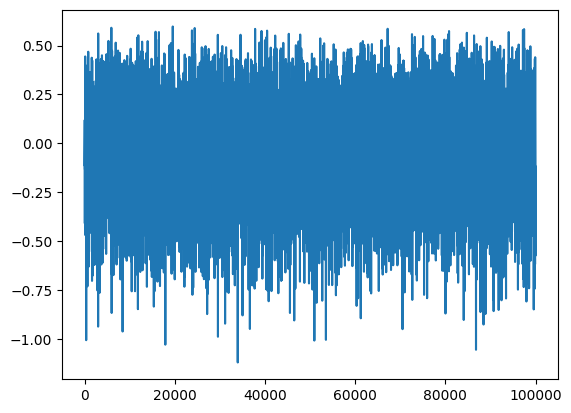

In [ ]:
train_val, test = nonlinear_benchmarks.WienerHammerBenchMark()
plt.plot(train_val.y)
type(train_val)

The data is store in a `Input_output_data` class, which provides customized access. We want to write a function, which exports the underlying data to hdf5 files.

In [ ]:
u = train_val.atleast_2d().u
u.shape

(100000, 1)

In [ ]:
#| export
def write_dataset(
     group: h5py.File | h5py.Group,
     ds_name: str,
     data: np.ndarray,
     dtype: str = 'f4',
     chunks: tuple[int, ...]|None = None
     ) -> None:
     group.create_dataset(ds_name, data=data, dtype=dtype, chunks=chunks)

In [ ]:
tmp_dir = Path('./tmp/')
os.makedirs(tmp_dir,exist_ok=True)
tmp_file = tmp_dir / 'tmp.hdf5'
with h5py.File(tmp_file,'w') as f:
    write_dataset(f,'u',u)

with h5py.File(tmp_file,'r') as f:
    hdf_u = f['u'][:]
    test_ne(hdf_u.dtype,u.dtype)
    test_eq(hdf_u,u.astype('f4'))

In [ ]:
#| export
def write_array(
        group: h5py.File | h5py.Group,
        ds_name: str,
        data: np.ndarray,
        dtype: str = 'f4',
        chunks: tuple[int, ...]|None = None
    ) -> None:
    'Writes a 2d numpy array rowwise to a hdf5 file.'
    for i in range(data.shape[1]):
        write_dataset(group, f'{ds_name}{i}', data[:,i], dtype, chunks)

In [ ]:
with h5py.File(tmp_file,'w') as f:
    write_array(f,'u',u)

with h5py.File(tmp_file,'r') as f:
    hdf_u = f['u0'][:]
    test_ne(hdf_u.dtype,u.dtype)
    test_ne(hdf_u,u.astype('f4'))
    test_eq(hdf_u[:,None],u.astype('f4'))

In [ ]:
#| export
def iodata_to_hdf5(iodata:Input_output_data, # data to save to file
            hdf_dir:Path, # Export directory for hdf5 files
            f_name:str = None # name of hdf5 file without '.hdf5' ending
            ) -> Path:
    data_2d = iodata.atleast_2d()
    u,y = data_2d.u, data_2d.y
    
    os.makedirs(hdf_dir,exist_ok=True)
    if f_name is None: f_name = iodata.name
    
    hdf_path = Path(hdf_dir) / f'{f_name}.hdf5'.replace(" ", "_")
    with h5py.File(hdf_path,'w') as f:
        write_array(f,'u',u)
        write_array(f,'y',y)
        
        # Save sampling_rate and init_window_size as attributes
        if iodata.sampling_time is not None:
            f.attrs['fs'] = 1/iodata.sampling_time
        if iodata.state_initialization_window_length is not None:
            f.attrs['init_sz'] = iodata.state_initialization_window_length

    return hdf_path 

In [ ]:
fname = iodata_to_hdf5(train_val,tmp_dir)

with h5py.File(fname,'r') as f:
    hdf_u = f['u0'][:]
    hdf_y = f['y0'][:]
    test_eq(hdf_u[:,None],train_val.atleast_2d().u.astype('f4'))
    test_eq(hdf_y[:,None],train_val.atleast_2d().y.astype('f4'))

Let us evaluate how the general shape of the downloaded datasets looks like

In [ ]:
for bench in nonlinear_benchmarks.all_splitted_benchmarks:
    train,test = bench(atleast_2d=True,always_return_tuples_of_datasets=True)
    print(type(train))
    print(type(train[0]))
    break

<class 'tuple'>
<class 'nonlinear_benchmarks.utilities.Input_output_data'>


With the correct flags set, all datasets have a consistent training and test tuple of one or more elements of type `Input_output_data`. We will transform that in a training, validation and test tuple, which we will then save with a single function.

In [ ]:
# for bench in nonlinear_benchmarks.all_not_splitted_benchmarks:
#     train = bench()
#     if len(train) == 2:
#         train, test = train
#         # print('\n'.join(map(str,train)))
#         if isinstance(train,list):
#             print(len(train))
#             print(train[0].name)

Only the datasets in `nonlinear_benchmarks.all_splitted_benchmarks` have a consistent output form. The other benchmarks have random splits

In [ ]:
#| export
def dataset_to_hdf5(train:tuple, #tuple of Input_output_data for training
                    valid:tuple,#tuple of Input_output_data for validation
                    test:tuple,#tuple of Input_output_data for test
                    save_path: Path, #directory the files are written to, created if it does not exist
                    train_valid: tuple = None # optional tuple of unsplit Input_output_data for training and validation
                    ) -> None:
    'Save a dataset consisting of training, validation, and test set in hdf5 format in seperate subdirectories'
    save_path = Path(save_path)
    
    dict_data = {'train':train,
                 'valid':valid,
                 'test':test,
                 'train_valid':train_valid}
    for subset,ds_entries in dict_data.items():
        if ds_entries is None: continue
        if isinstance(ds_entries,tuple):
            if not isinstance(ds_entries[0],Input_output_data): raise ValueError(f'Data has to be stored in tuples of Input_output_data. Got {type(ds_entries[0])}')
        else:
            if not isinstance(ds_entries,Input_output_data): raise ValueError(f'Data has to be stored in Input_output_data. Got {type(ds_entries)}')
            dict_data[subset] = (ds_entries,)

    os.makedirs(save_path,exist_ok=True)

    for subset,ds_entries in dict_data.items():
        if ds_entries is None: continue
        for idx,iodata in enumerate(ds_entries):
            iodata_to_hdf5(iodata,save_path / subset,f'{subset}_{idx}')

In [ ]:
train_val, test = nonlinear_benchmarks.WienerHammerBenchMark()
split_idx = 90_000
train = train_val[:split_idx]
valid = train_val[split_idx:]
test = test

In [ ]:
dataset_to_hdf5(train,valid,test,tmp_dir)
dataset_to_hdf5((train,),valid,test,tmp_dir)

## Download Utilities

In [ ]:
#| export
import requests
import io
import os
import zipfile
import rarfile

In [ ]:
#| export
def unzip_download(url:str, #url to file to download
                   extract_dir: Path = Path('.') #directory the archive is extracted to
                   ) -> None:
    'downloads a zip archive to ram and extracts it'
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_dir)

In [ ]:
#| export
def unrar_download(url:str, #url to file to download
                   extract_dir: Path = Path('.') #directory the archive is extracted to
                   ) -> None:
    'downloads a rar archive to ram and extracts it'
    response = requests.get(url)
    with rarfile.RarFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_dir)

In [ ]:
#| export
def download(url:str, #url to file to download
             target_dir: Path = Path('.')
             ) -> Path:
    fname = Path(url).name
    if os.path.isfile(fname): return
    response = requests.get(url)
    p_name = Path(target_dir).joinpath(fname)
    with open(p_name, "wb") as file:
        file.write(response.content)
    return p_name

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()